In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import optuna
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import xgboost as xgb
from prophet import Prophet
import torch
import torch.nn as nn
import torch.optim as optim

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 9/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 10/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 11/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 12/50
231/231 ━━━━━━━━━━━━━━━━━━━━

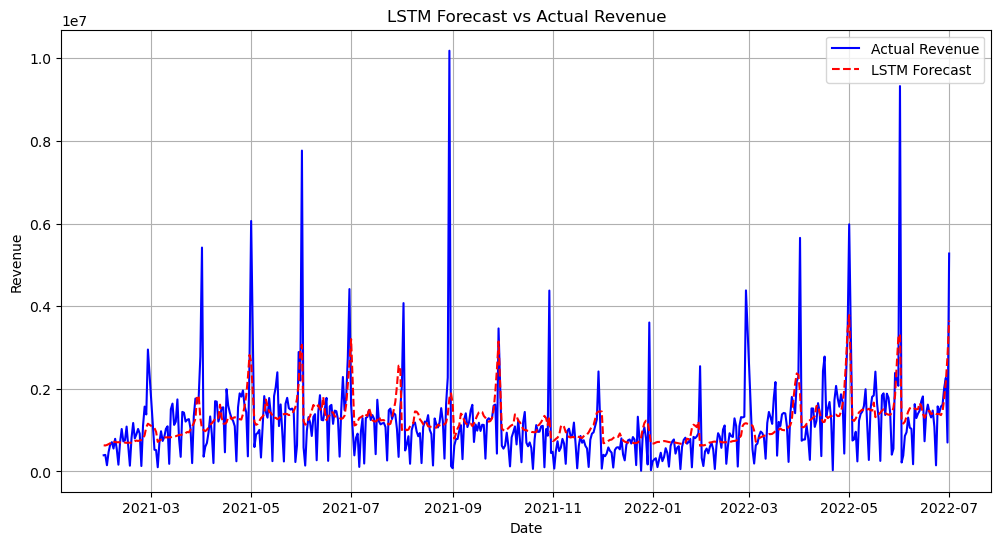

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Đọc dữ liệu
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

# Chuyển đổi cột Date sang datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Tổng hợp theo ngày
train_time_series = train_df.groupby("Date")[["Revenue"]].sum()
test_time_series = test_df.groupby("Date")[["Revenue"]].sum()

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_time_series)
test_scaled = scaler.transform(test_time_series)

# Tạo dữ liệu dạng (X, y) cho LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Sử dụng 30 ngày để dự báo
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape dữ liệu để phù hợp với LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nLSTM Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="LSTM Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("LSTM Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

Epoch 1/100


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 9/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 10/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 11/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 12/100
231/231 ━━━━━━━━━━━━━━━━━━━━

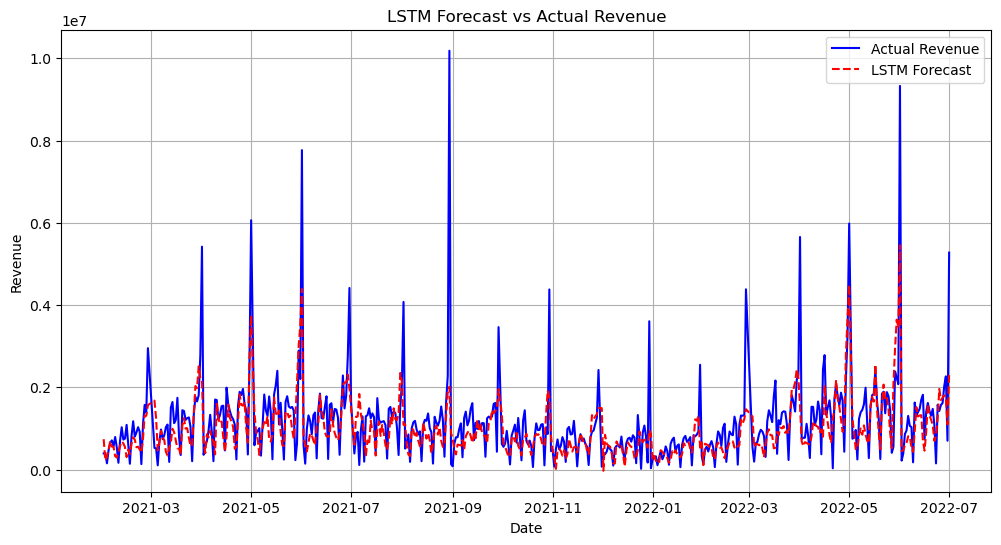

In [2]:
# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nLSTM Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="LSTM Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("LSTM Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 9/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 10/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 11/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 12/100
231/231 ━━━━━━━━

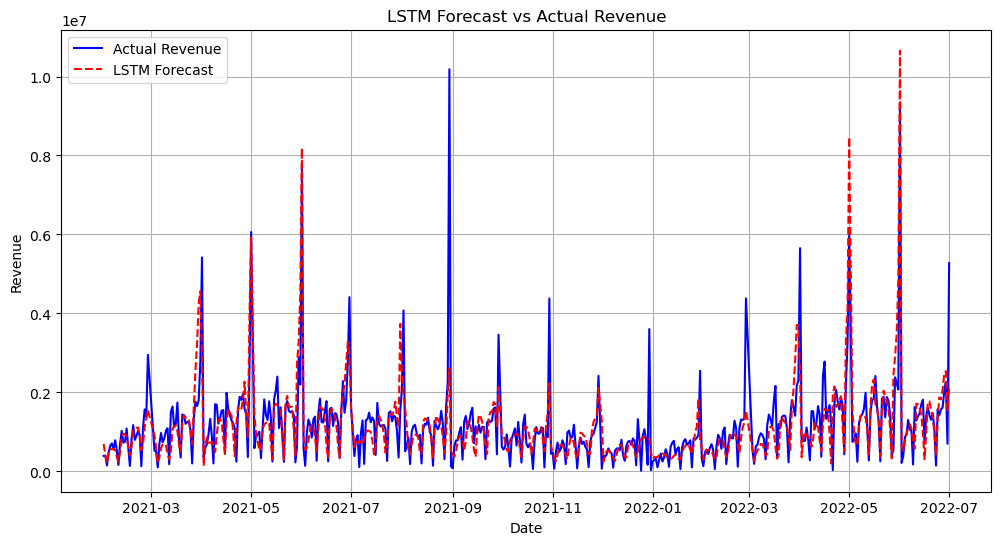

In [3]:
# Xây dựng mô hình LSTM với nhiều lớp hơn
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nLSTM Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="LSTM Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("LSTM Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()


Epoch 1/50


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 9/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 10/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 11/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 12/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/st

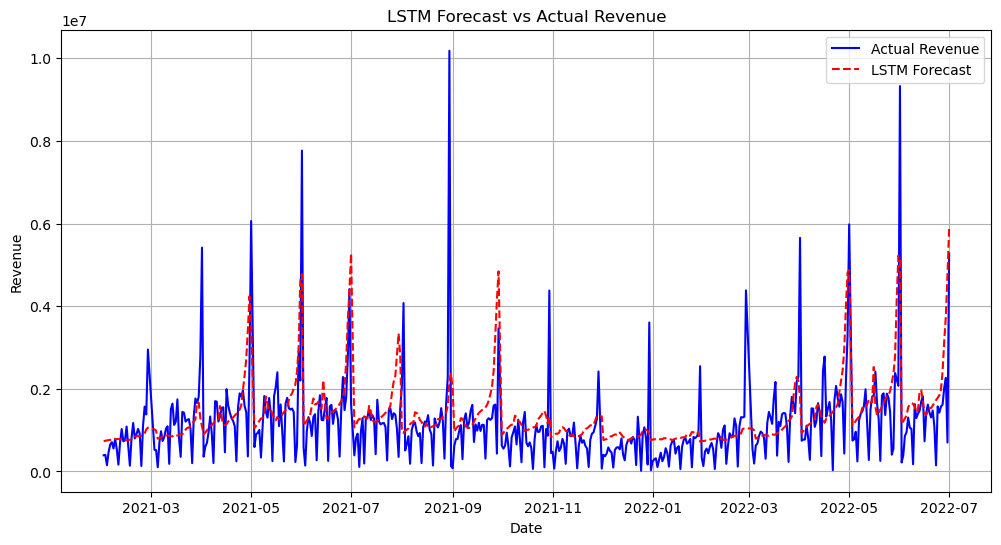

In [4]:
# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nLSTM Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="LSTM Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("LSTM Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.9000 - val_loss: 0.0036
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0919 - val_loss: 0.0033
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0134 - val_loss: 0.0032
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0062 - val_loss: 0.0034
Epoch 9/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 10/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 11/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0062 - val_loss: 0.0077
Epoch 12/50
231/231 ━━━━━━━━━━━━━━━━━━━━

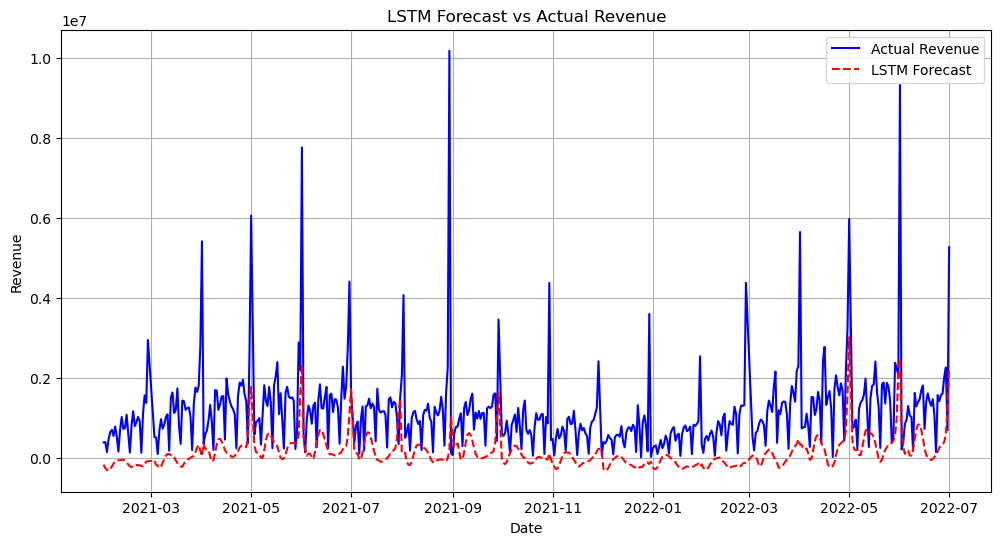

In [7]:
# Xây dựng mô hình LSTM với Batch Normalization
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(seq_length, 1)),  # Giảm từ 64 xuống 32 neuron
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(32, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),

    Dense(25),
    Dense(1)
])

# Dùng Adam với learning rate 0.0005
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nLSTM Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="LSTM Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("LSTM Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 9/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 10/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 11/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 12/1

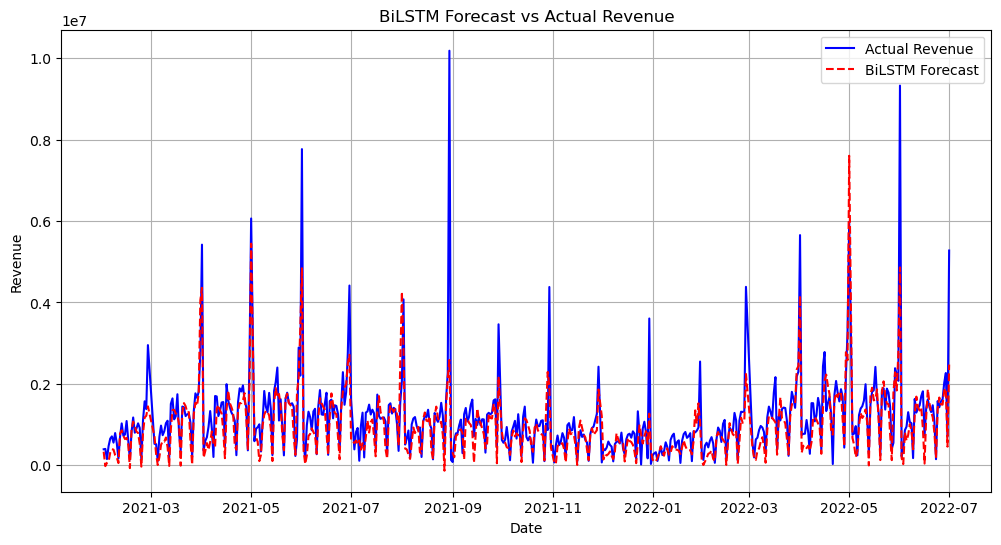

In [10]:
# Xây dựng mô hình BiLSTM
model = Sequential([
    Bidirectional(LSTM(200, return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.3),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nBiLSTM Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="BiLSTM Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("BiLSTM Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

Epoch 1/100


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 2/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 3/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 4/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 5/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 6/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 7/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 8/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 9/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 10/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 11/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 12/100
229/229 ━

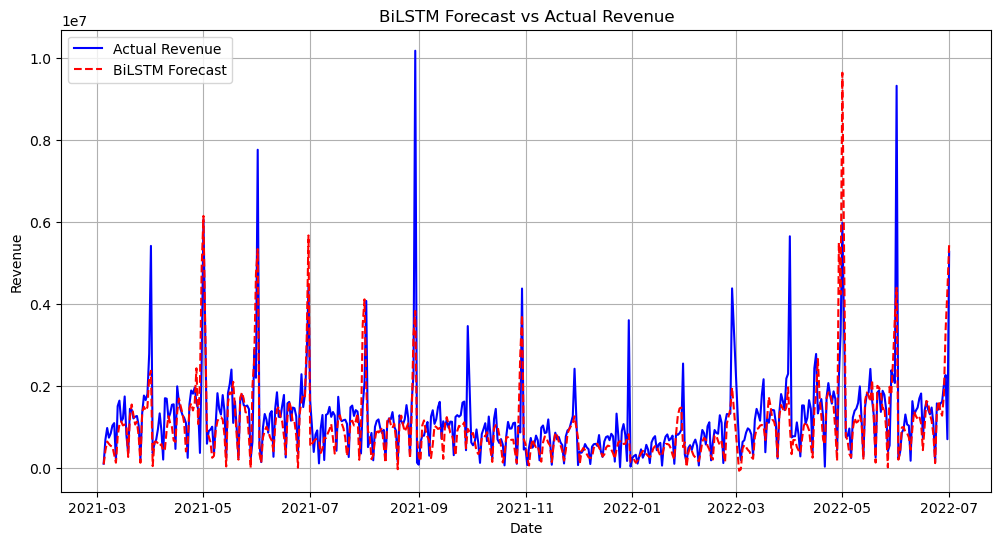

In [11]:
seq_length = 60  # Tăng từ 30 lên 60 ngày
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape dữ liệu để phù hợp với BiLSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình BiLSTM
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(seq_length, 1))),
    Dropout(0.3),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nBiLSTM Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="BiLSTM Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("BiLSTM Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Input, Attention

Epoch 1/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 0.0073 - val_loss: 0.0033
Epoch 2/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 3/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 4/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.0064 - val_loss: 0.0034
Epoch 5/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 6/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 7/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 8/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 9/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 10/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 11/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 12/100
229/22

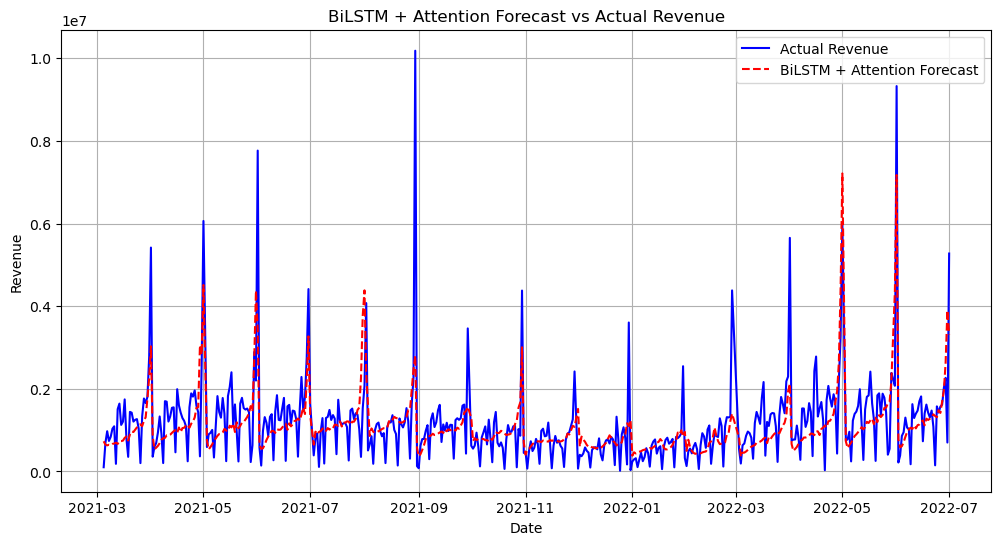

In [14]:
seq_length = 60  # Sử dụng 60 ngày để dự báo
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape dữ liệu
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình BiLSTM với Attention
input_layer = Input(shape=(seq_length, 1))
bilstm = Bidirectional(LSTM(100, return_sequences=True))(input_layer)
drop1 = Dropout(0.3)(bilstm)

# Attention Layer
attention = Attention()([drop1, drop1])
drop2 = Dropout(0.3)(attention)

bilstm2 = Bidirectional(LSTM(100, return_sequences=False))(drop2)
drop3 = Dropout(0.3)(bilstm2)

dense1 = Dense(50, activation='relu')(drop3)
out = Dense(1)(dense1)

model = Model(inputs=input_layer, outputs=out)
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nBiLSTM + Attention Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="BiLSTM + Attention Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("BiLSTM + Attention Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 9/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 10/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 11/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 12/100
231/231 ━━━━━━━━

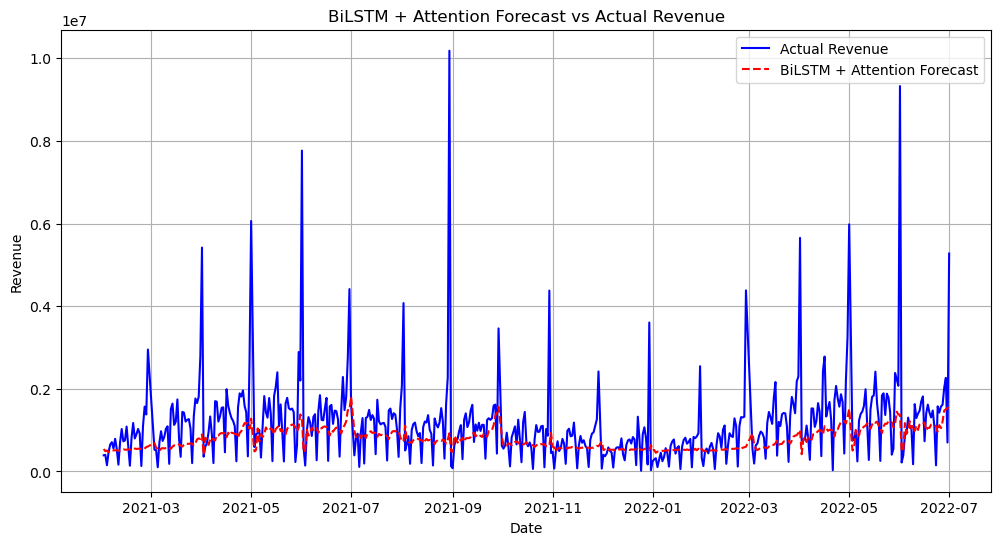

In [15]:
seq_length = 30  # Sử dụng 60 ngày để dự báo
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape dữ liệu
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình BiLSTM với Attention
input_layer = Input(shape=(seq_length, 1))
bilstm = Bidirectional(LSTM(100, return_sequences=True))(input_layer)
drop1 = Dropout(0.3)(bilstm)

# Attention Layer
attention = Attention()([drop1, drop1])
drop2 = Dropout(0.3)(attention)

bilstm2 = Bidirectional(LSTM(100, return_sequences=False))(drop2)
drop3 = Dropout(0.3)(bilstm2)

dense1 = Dense(50, activation='relu')(drop3)
out = Dense(1)(dense1)

model = Model(inputs=input_layer, outputs=out)
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nBiLSTM + Attention Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="BiLSTM + Attention Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("BiLSTM + Attention Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()


Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 5/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 6/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 7/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 8/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 9/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 10/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 11/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 12/100
232/232 ━━━━━━━━

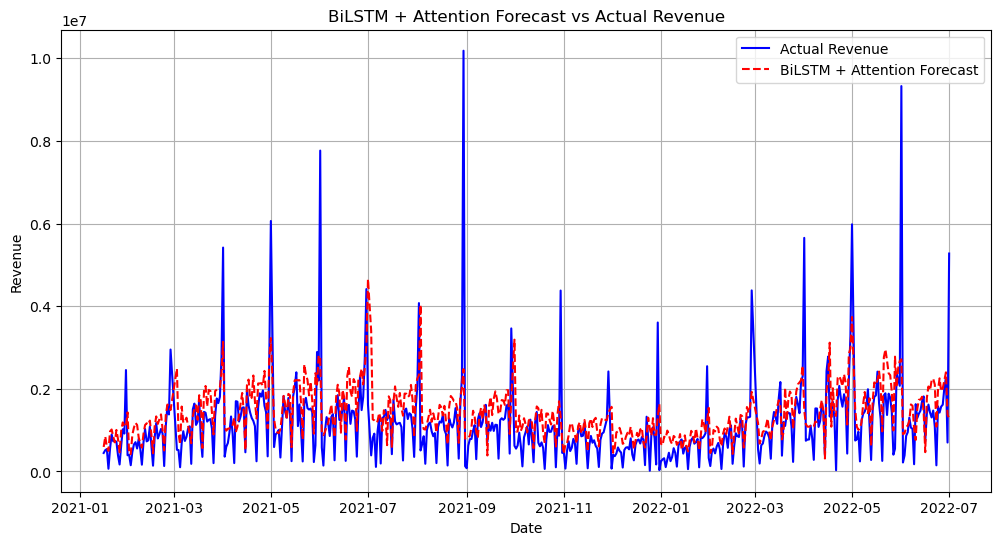

In [16]:
seq_length = 15  # Sử dụng 60 ngày để dự báo
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape dữ liệu
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình BiLSTM với Attention
input_layer = Input(shape=(seq_length, 1))
bilstm = Bidirectional(LSTM(100, return_sequences=True))(input_layer)
drop1 = Dropout(0.3)(bilstm)

# Attention Layer
attention = Attention()([drop1, drop1])
drop2 = Dropout(0.3)(attention)

bilstm2 = Bidirectional(LSTM(100, return_sequences=False))(drop2)
drop3 = Dropout(0.3)(bilstm2)

dense1 = Dense(50, activation='relu')(drop3)
out = Dense(1)(dense1)

model = Model(inputs=input_layer, outputs=out)
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nBiLSTM + Attention Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="BiLSTM + Attention Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("BiLSTM + Attention Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Input, Attention, MultiHeadAttention
from tensorflow.keras.models import Model

Epoch 1/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - loss: 0.1598 - val_loss: 0.0030
Epoch 2/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 3/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 4/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 5/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 6/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 7/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 8/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 9/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 10/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 11/100
231/231 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 12/100

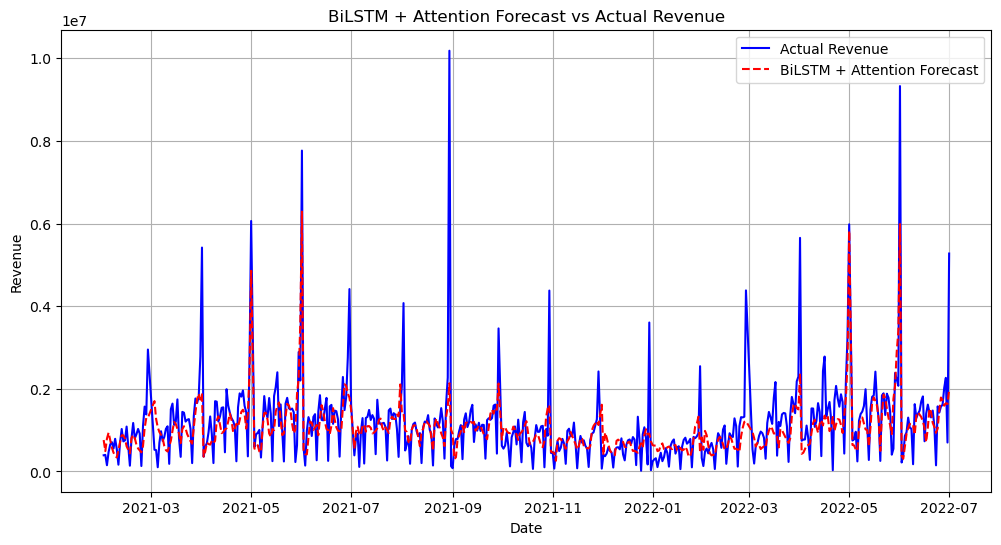

In [19]:
seq_length = 30  # Sử dụng 30 ngày để dự báo
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape dữ liệu
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình BiLSTM + Multi-Head Attention
def build_model():
    inputs = Input(shape=(seq_length, 1))
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    
    attention = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    x = tf.keras.layers.Add()([x, attention])  # Residual connection
    x = tf.keras.layers.LayerNormalization()(x)
    
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model()

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Dự báo
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nBiLSTM + Attention Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="BiLSTM + Attention Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("BiLSTM + Attention Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

In [25]:
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

# Chuyển đổi cột Date sang datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Tổng hợp theo ngày
train_time_series = train_df.groupby("Date")["Revenue"].sum().reset_index()
test_time_series = test_df.groupby("Date")["Revenue"].sum().reset_index()


XGBoost Model Evaluation for Revenue:
R2 Score: 0.5874
MAPE: 0.5952
RMSE: 654431.9643


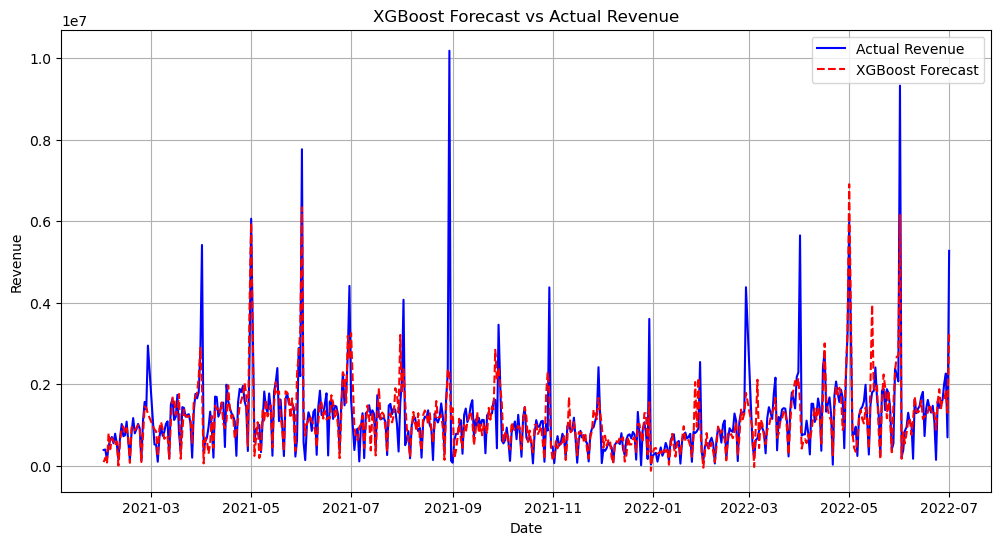

In [26]:
# XGBoost Model
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_time_series[["Revenue"]])
test_scaled = scaler.transform(test_time_series[["Revenue"]])

def create_lag_features(data, lags=30):
    X, y = [], []
    for i in range(lags, len(data)):
        X.append(data[i-lags:i])
        y.append(data[i])
    return np.array(X).reshape(len(X), -1), np.array(y)

X_train, y_train = create_lag_features(train_scaled)
X_test, y_test = create_lag_features(test_scaled)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_pred = scaler.inverse_transform(xgb_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

r2_xgb = r2_score(y_test_actual, xgb_pred)
mape_xgb = mean_absolute_percentage_error(y_test_actual, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test_actual, xgb_pred))

print("XGBoost Model Evaluation for Revenue:")
print(f"R2 Score: {r2_xgb:.4f}")
print(f"MAPE: {mape_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_time_series["Date"][30:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series["Date"][30:], xgb_pred, label="XGBoost Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("XGBoost Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()


XGBoost Model Evaluation for Revenue:
R2 Score: 0.5243
MAPE: 0.7351
RMSE: 702725.1523


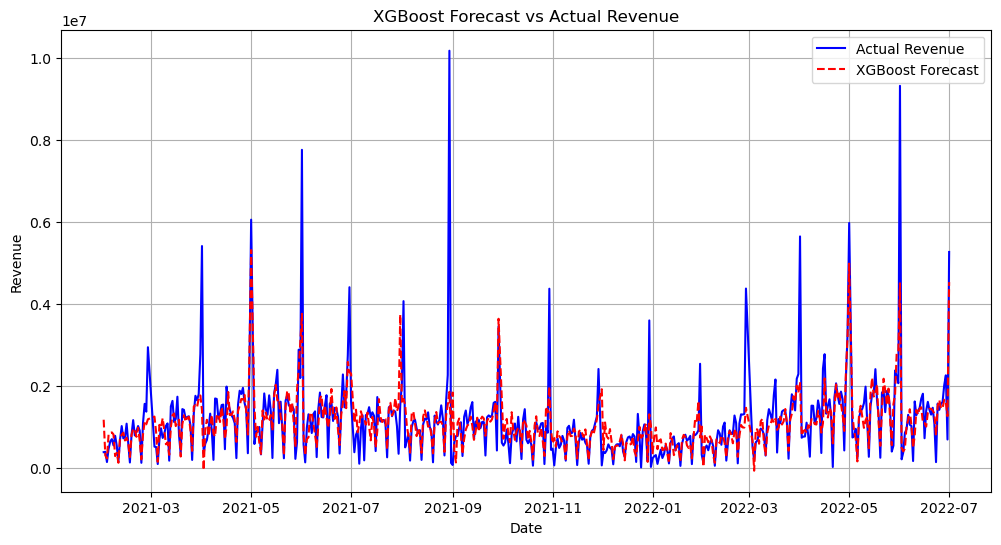

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Đọc dữ liệu
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

# Chuyển đổi cột Date sang datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Tổng hợp theo ngày
train_time_series = train_df.groupby("Date")["Revenue"].sum()
test_time_series = test_df.groupby("Date")["Revenue"].sum()

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_time_series.values.reshape(-1, 1))
test_scaled = scaler.transform(test_time_series.values.reshape(-1, 1))

# Tạo dữ liệu dạng (X, y) cho XGBoost
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length].flatten())
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Sử dụng 30 ngày để dự báo
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Khởi tạo mô hình XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)

# Huấn luyện mô hình
xgb_model.fit(X_train, y_train)

# Dự báo trên tập kiểm tra
y_pred_scaled = xgb_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nXGBoost Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="XGBoost Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("XGBoost Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb

# Đọc dữ liệu
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

# Chuyển đổi cột Date sang datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Tổng hợp theo ngày
train_time_series = train_df.groupby("Date")["Revenue"].sum()
test_time_series = test_df.groupby("Date")["Revenue"].sum()

# Tạo đặc trưng
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['lag1'] = df['Revenue'].shift(1)
    df['lag7'] = df['Revenue'].shift(7)
    df['lag30'] = df['Revenue'].shift(30)
    df.dropna(inplace=True)
    return df

train_features = create_features(train_time_series.to_frame())
test_features = create_features(test_time_series.to_frame())

X_train, y_train = train_features.drop(columns=['Revenue']), train_features['Revenue']
X_test, y_test = test_features.drop(columns=['Revenue']), test_features['Revenue']

# Thiết lập tham số cho GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(xgb_model, param_grid, scoring='r2', cv=tscv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Lấy tham số tối ưu
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Huấn luyện lại mô hình với tham số tối ưu
best_xgb = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_xgb.fit(X_train, y_train)

# Dự báo
y_pred = best_xgb.predict(X_test)

# Đánh giá mô hình
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nOptimized XGBoost Model Evaluation:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}

Optimized XGBoost Model Evaluation:
R2 Score: 0.5277
MAPE: 0.7313
RMSE: 700193.9372


[I 2025-02-24 15:08:47,894] A new study created in memory with name: no-name-a342a935-ab78-4763-a880-b54b36f0979c
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20256\3564849017.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20256\3564849017.py:45: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20256\3564849017.py:46: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0


Optimized XGBoost Model Evaluation for Revenue:
R2 Score: 0.6213
MAPE: 0.5949
RMSE: 626960.4980


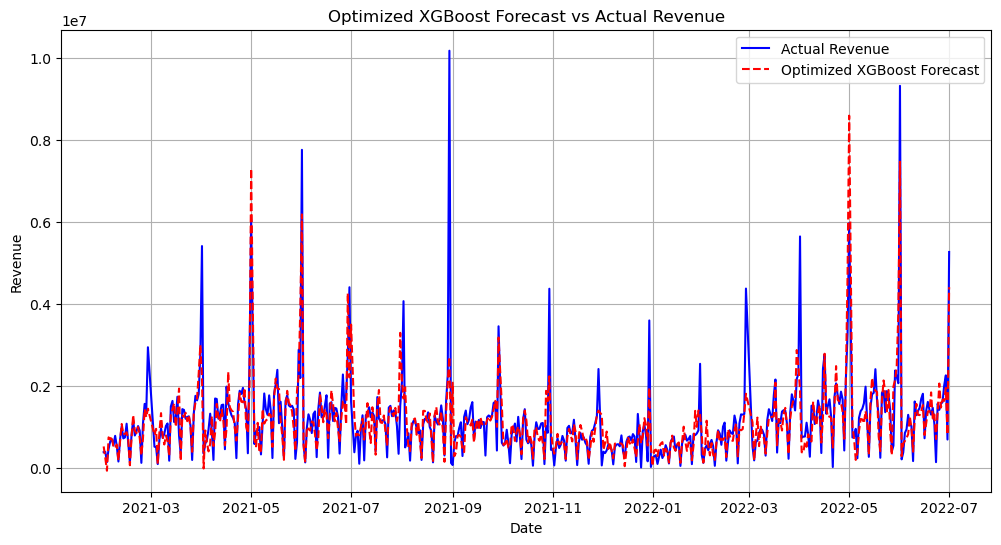

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb

# Đọc dữ liệu
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

# Chuyển đổi cột Date sang datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Tổng hợp theo ngày
train_time_series = train_df.groupby("Date")["Revenue"].sum().reset_index()
test_time_series = test_df.groupby("Date")["Revenue"].sum().reset_index()

def create_lag_features(data, lags=30):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Revenue'].shift(lag)
    df.dropna(inplace=True)
    return df

# Tạo đặc trưng lag features
train_time_series = create_lag_features(train_time_series)
test_time_series = create_lag_features(test_time_series)

# Chia tập train/test
X_train, X_val, y_train, y_val = train_test_split(
    train_time_series.drop(columns=["Date", "Revenue"]), train_time_series["Revenue"], test_size=0.2, random_state=42
)
X_test = test_time_series.drop(columns=["Date", "Revenue"])
y_test = test_time_series["Revenue"]

# Hàm mục tiêu cho Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    model = xgb.XGBRegressor(**params, objective="reg:squarederror", random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return r2_score(y_val, y_pred)

# Chạy Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Huấn luyện mô hình với tham số tối ưu
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)
best_model.fit(X_train, y_train)

# Dự báo trên tập kiểm tra
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nOptimized XGBoost Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series["Date"], y_test, label="Actual Revenue", color='blue')
plt.plot(test_time_series["Date"], y_pred, label="Optimized XGBoost Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Optimized XGBoost Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - loss: 0.0077 - val_loss: 0.0034
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 9/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.0062 - val_loss: 0.0034
Epoch 10/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 11/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 12/50
231/231 ━━━━━━━━━━

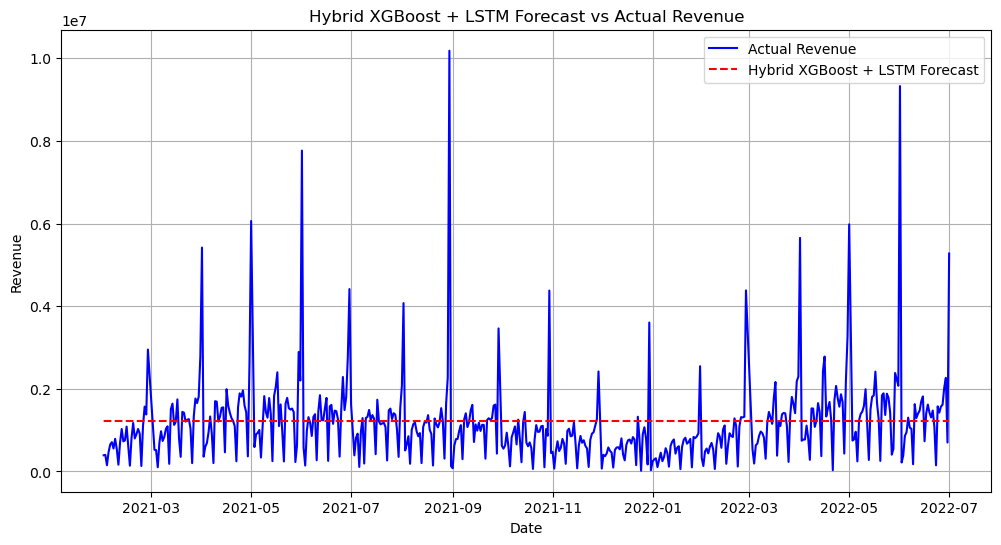

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Đọc dữ liệu
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

# Chuyển đổi cột Date sang datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Tổng hợp theo ngày
train_time_series = train_df.groupby("Date")["Revenue"].sum()
test_time_series = test_df.groupby("Date")["Revenue"].sum()

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_time_series.values.reshape(-1, 1))
test_scaled = scaler.transform(test_time_series.values.reshape(-1, 1))

# Tạo dữ liệu dạng (X, y) cho XGBoost
seq_length = 30

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Chuyển X thành dạng phù hợp cho XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Huấn luyện mô hình XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train_xgb, y_train)

# Trích xuất đặc trưng từ XGBoost
train_features = xgb_model.apply(X_train_xgb)
test_features = xgb_model.apply(X_test_xgb)

# Chuẩn hóa đặc trưng
scaler_features = MinMaxScaler()
train_features_scaled = scaler_features.fit_transform(train_features)
test_features_scaled = scaler_features.transform(test_features)

# Chuyển đổi dữ liệu cho LSTM
X_train_lstm = train_features_scaled.reshape((train_features_scaled.shape[0], train_features_scaled.shape[1], 1))
X_test_lstm = test_features_scaled.reshape((test_features_scaled.shape[0], test_features_scaled.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình LSTM
model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test), verbose=1)

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test_lstm)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
r2 = r2_score(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("\nHybrid XGBoost + LSTM Model Evaluation for Revenue:")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Vẽ biểu đồ đánh giá kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index[seq_length:], y_test_actual, label="Actual Revenue", color='blue')
plt.plot(test_time_series.index[seq_length:], y_pred, label="Hybrid XGBoost + LSTM Forecast", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Hybrid XGBoost + LSTM Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()


15:00:31 - cmdstanpy - INFO - Chain [1] start processing
15:00:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Evaluation for Revenue:
R2 Score: 0.0079
MAPE: 1.2622
RMSE: 1000411.7613


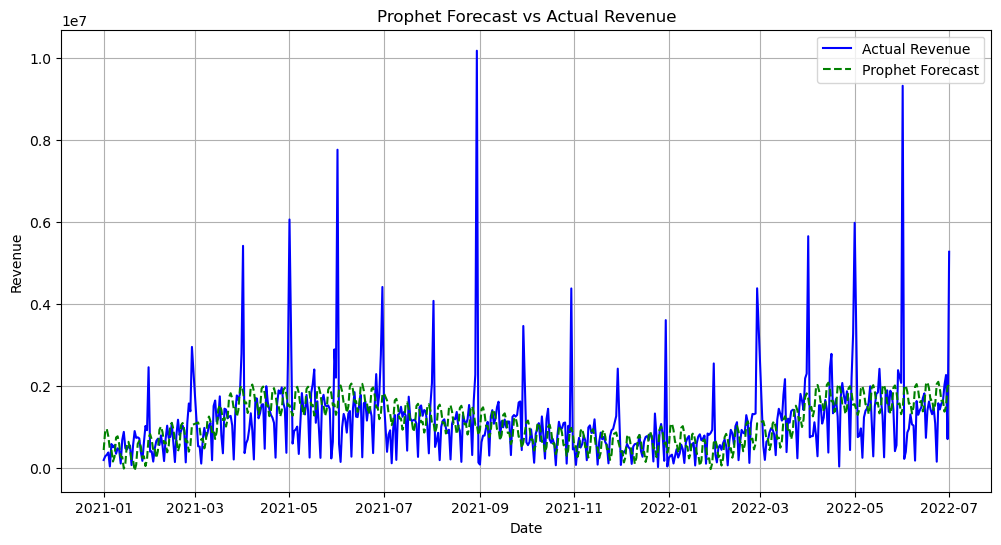

In [27]:
# Prophet Model
prophet_df = train_time_series.rename(columns={"Date": "ds", "Revenue": "y"})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(test_time_series), freq='D')
forecast = prophet_model.predict(future)
prophet_pred = forecast['yhat'][-len(test_time_series):].values

y_test_actual_prophet = test_time_series["Revenue"].values
r2_prophet = r2_score(y_test_actual_prophet, prophet_pred)
mape_prophet = mean_absolute_percentage_error(y_test_actual_prophet, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_test_actual_prophet, prophet_pred))

print("Prophet Model Evaluation for Revenue:")
print(f"R2 Score: {r2_prophet:.4f}")
print(f"MAPE: {mape_prophet:.4f}")
print(f"RMSE: {rmse_prophet:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_time_series["Date"], y_test_actual_prophet, label="Actual Revenue", color='blue')
plt.plot(test_time_series["Date"], prophet_pred, label="Prophet Forecast", linestyle='dashed', color='green')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Prophet Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Transformer Model
transformer_model = TimeTransformer(h=30, input_size=30)
ts_train = TimeSeriesDataset(df=train_time_series, ds_col='Date', y_col='Revenue')
ts_test = TimeSeriesDataset(df=test_time_series, ds_col='Date', y_col='Revenue')
nf = NeuralForecast(models=[transformer_model], freq='D')
nf.fit(ts_train)
transformer_pred = nf.predict(ts_test)

y_test_actual_transformer = test_time_series["Revenue"].values
r2_transformer = r2_score(y_test_actual_transformer, transformer_pred)
mape_transformer = mean_absolute_percentage_error(y_test_actual_transformer, transformer_pred)
rmse_transformer = np.sqrt(mean_squared_error(y_test_actual_transformer, transformer_pred))

print("Transformer Model Evaluation for Revenue:")
print(f"R2 Score: {r2_transformer:.4f}")
print(f"MAPE: {mape_transformer:.4f}")
print(f"RMSE: {rmse_transformer:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_time_series["Date"], y_test_actual_transformer, label="Actual Revenue", color='blue')
plt.plot(test_time_series["Date"], transformer_pred, label="Transformer Forecast", linestyle='dashed', color='orange')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Transformer Forecast vs Actual Revenue")
plt.legend()
plt.grid()
plt.show()


NameError: name 'TimeTransformer' is not defined

In [29]:
from neuralforecast.models import TimeTransformer
from neuralforecast.core import NeuralForecast
from neuralforecast.data.datasets import AirPassengersDF
from neuralforecast.data.tsdataset import TimeSeriesDataset
from prophet import Prophet

2025-02-24 15:01:03,131	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-24 15:01:03,442	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


ImportError: cannot import name 'TimeTransformer' from 'neuralforecast.models' (c:\Users\ADMIN\anaconda3\Lib\site-packages\neuralforecast\models\__init__.py)